In [2]:
import pandas as pd
import numpy as np
from covid import utils
import matplotlib.pyplot as plt
import seaborn as sns

paths = utils.create_named_tuple('filepaths.txt')
config = utils.create_named_tuple(paths.config)
labels = utils.generate_labels_from_bins(config.age_bins)
bins = config.age_bins
population = pd.read_csv('data/temp_pop.csv')

In [4]:
population

,region_id,region,0-6,7-15,16-19,20-40,41-66,67+,population
0,301,OSLO,55837,64036,25672,265609,207877,77749,696780
1,1101,EIGERSUND,1132,1719,739,3858,4898,2439,14785
2,1103,STAVANGER,11735,16218,6740,43688,47283,18451,144115
3,1106,HAUGESUND,2636,3996,1831,10319,12823,5707,37312
4,1108,SANDNES,7589,10110,4057,23830,25653,9206,80445
...,...,...,...,...,...,...,...,...,...
351,5440,BERLEVÅG,47,61,42,223,341,214,928
352,5441,TANA,166,232,115,663,1052,600,2828
353,5442,NESSEBY,33,86,31,206,295,229,880
354,5443,BÅTSFJORD,150,197,97,649,761,346,2200


In [2]:
pop_eu = pd.read_csv('data/population_europe.csv', delimiter=";")
pop_eu = pop_eu.T.reset_index()
pop_eu.rename({'index': 'age_group', 0: 'population'}, axis=1, inplace=True)
pop_eu.drop(index=16, axis=0, inplace=True)
pop_eu.population = pop_eu.population.apply(lambda x:int(str(x).replace(" ", ""))*1000)
pop_eu['age_low'] = pop_eu.age_group.apply(lambda x: str(x).split("-")[0]).astype(int)
pop_eu['age_high'] = pop_eu.age_group.apply(lambda x: str(x).split("-")[1]).astype(int)
pop_eu.drop('age_group', axis=1, inplace=True)
pop_eu
age = []
age_pop = [] 
for row in pop_eu.iterrows():
    info = row[1]
    age_diff = info.age_high - info.age_low
    for i in range(info.age_low, info.age_high+1):
        age.append(i)
        age_pop.append(info.population/age_diff)
new_pop_eu = pd.DataFrame(np.array([age, age_pop]).T, columns=['age', 'population'])
new_pop_eu.age = new_pop_eu.age.astype(int)
new_pop_eu.population = new_pop_eu.population.astype(int)

FileNotFoundError: [Errno 2] No such file or directory: 'data/population_europe.csv'

In [36]:
df = pd.read_csv('data/contact_data.csv')
df.contact_age_0 = pd.cut(df['contact_age_0'], bins=bins+[110], labels=labels, include_lowest=True)
df.contact_age_1 = pd.cut(df['contact_age_1'], bins=bins+[110], labels=labels, include_lowest=True)
df_mat = pd.DataFrame(df[df.columns[:-2]].groupby(['contact_age_0', 'contact_age_1']).sum()).reset_index()
N_survey_0 = df.contact_age_0.value_counts()[labels]
pop_0 = [N_survey_0[l[1].contact_age_0] for l in df_mat.iterrows()]
df_mat['pop_0'] = pop_0
for col in df_mat.columns[2:-1]:
    df_mat[col] = df_mat[col]/(df_mat.pop_0)

N_eu = pd.read_csv('data/population_europe_2008.csv')
N_eu.age = pd.cut(N_eu['age'], bins=bins+[110], labels=labels, include_lowest=True)
N_eu = N_eu.groupby('age').sum()['population']
N_eu_tot = N_eu.sum()
N_norway = population[population.columns[2:-1]].sum()
N_norway_tot = np.sum(N_norway)

matrices = []
for col in ['home', 'school', 'work', 'public']:
    matrix = pd.pivot_table(df_mat, values=col, index='contact_age_0', columns='contact_age_1')
    corrected_matrix = np.zeros((matrix.shape))
    for i, a_i in enumerate(labels):
        for j, a_j in enumerate(labels):
            corrected_matrix[i][j] = matrix[a_i][a_j] * (N_eu_tot * N_norway[a_j])/(N_eu[a_j] * N_norway_tot) # Density correction
    symmetric_matrix = np.zeros((matrix.shape))
    for i, a_i in enumerate(labels):
        for j, a_j in enumerate(labels):
            symmetric_matrix[i][j] = 1/(N_norway[a_i]+N_norway[a_j]) * (corrected_matrix[i][j] * N_norway[a_i] + corrected_matrix[j][i] * N_norway[a_j]) # Symmetry
    matrices.append(symmetric_matrix)

In [38]:
weights = [0.290839, 0.240549, 0.22188, 0.246732]
combined = np.sum(np.array([np.array(matrices[i])*weights[i] for i in range(len(matrices))]), axis=0)

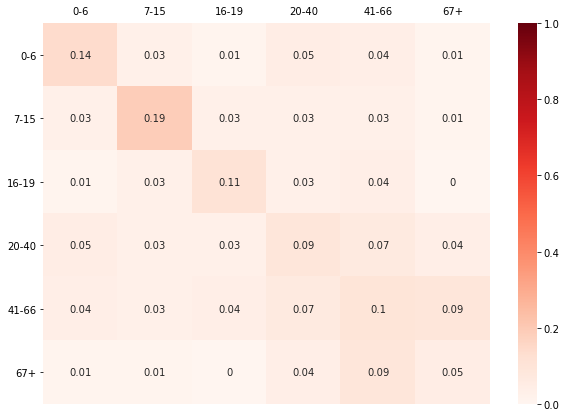

In [39]:
plt.figure(figsize=(10,7))
sns.heatmap(np.round(combined,2), annot=True, vmin=0, vmax=1, cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.yticks(rotation=0)
plt.show()

In [58]:
# Generate data from polymod
contact = pd.read_csv('data/polymod_contact.csv')
hh = pd.read_csv('data/polymod_household.csv')
p = pd.read_csv('data/polymod_participant.csv')
day = pd.read_csv('data/polymod_day.csv')
contact = contact.merge(p.drop('part_gender', axis=1), on='part_id')
contact = contact.merge(hh.drop('hh_size', axis=1), on='hh_id')
contact = contact.merge(day.drop(columns=['sday_id', 'day', 'month', 'year']), on='part_id')
contact.drop(columns=['frequency_multi', 'phys_contact', 'duration_multi', 'cnt_otherplace',
                      'cnt_age_est_min', 'cnt_age_est_max', 'cont_id', 'cnt_gender', 'part_id', 'hh_id'], inplace=True)
contact.dropna(inplace=True)
remap = {
    'cnt_age_exact': int,
    'part_age': int,
    'dayofweek': int,
    'cnt_home': bool,
    'cnt_work': bool,
    'cnt_school': bool,
    'cnt_transport': bool,
    'cnt_leisure': bool
}
contact = contact.astype(remap)
contact = contact[['cnt_age_exact', 'part_age', 'cnt_home', 'cnt_work', 'cnt_school', 'cnt_transport',
       'cnt_leisure', 'country', 'dayofweek']]
def renamer():
    current = ['cnt_age_exact', 'part_age', 'cnt_home', 'cnt_work', 'cnt_school', 'cnt_transport', 'cnt_leisure', 'country', 'dayofweek']
    columns = ['contact_age_0','contact_age_1','home','work','school','transport','leisure','country','dayofweek']
    return {current[i]: columns[i] for i in range(len(current))}
mapper = renamer()
contact.rename(mapper=mapper, axis=1, inplace=True)
contact.sort_values('contact_age_0', inplace=True)

C:\Users\bendikno\Miniconda3\envs\epidemics\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (6,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [36]:
df = pd.read_csv('data/deaths-us.csv')
df['age_0'] = df['Age Group'].apply(lambda x: int(str(x).split('-')[0]))
df['age_1'] = df['Age Group'].apply(lambda x: int(str(x).split('-')[1]))
df.drop(columns=['Age Group','Percent Cases', 'Percent Deaths'], inplace=True)

age = []
cases = []
deaths = []
for row in df.iterrows():
    info = row[1]
    interval = info.age_1 - info.age_0 + 1
    for i in range(info.age_0, info.age_1+1):
        age.append(i)
        cases.append(info.cases/interval)
        deaths.append(info.deaths/interval) 

df_new = pd.DataFrame(data={"age": np.array(age).T, "cases": np.array(cases).T.astype(int), "deaths": np.round(np.array(deaths).T,2)})
df_new.to_csv('data/deaths_by_age.csv', index=False)

In [46]:
df = pd.read_csv('data/owid-covid-data.csv')
df[df.iso_code == 'NOR']

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
56466,NOR,Europe,Norway,2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,...,64800.057,0.2,114.316,5.31,19.6,20.7,NaN,3.6,82.4,0.957
56467,NOR,Europe,Norway,2020-02-26,1.0,1.0,NaN,NaN,NaN,NaN,...,64800.057,0.2,114.316,5.31,19.6,20.7,NaN,3.6,82.4,0.957
56468,NOR,Europe,Norway,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,64800.057,0.2,114.316,5.31,19.6,20.7,NaN,3.6,82.4,0.957
56469,NOR,Europe,Norway,2020-02-28,6.0,5.0,NaN,NaN,NaN,NaN,...,64800.057,0.2,114.316,5.31,19.6,20.7,NaN,3.6,82.4,0.957
56470,NOR,Europe,Norway,2020-02-29,15.0,9.0,NaN,NaN,NaN,NaN,...,64800.057,0.2,114.316,5.31,19.6,20.7,NaN,3.6,82.4,0.957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56888,NOR,Europe,Norway,2021-04-22,109581.0,444.0,479.571,735.0,1.0,4.000,...,64800.057,0.2,114.316,5.31,19.6,20.7,NaN,3.6,82.4,0.957
56889,NOR,Europe,Norway,2021-04-23,110061.0,480.0,476.286,736.0,1.0,4.000,...,64800.057,0.2,114.316,5.31,19.6,20.7,NaN,3.6,82.4,0.957
56890,NOR,Europe,Norway,2021-04-24,110390.0,329.0,463.714,736.0,0.0,4.000,...,64800.057,0.2,114.316,5.31,19.6,20.7,NaN,3.6,82.4,0.957
56891,NOR,Europe,Norway,2021-04-25,110612.0,222.0,443.143,736.0,0.0,4.000,...,64800.057,0.2,114.316,5.31,19.6,20.7,NaN,3.6,82.4,0.957


In [3]:
df = pd.read_csv('data/fhi_data_daily.csv')
df.dropna(inplace=True)
df = df[['I_new', 'date']]
df.date = pd.to_datetime(df.date)
df

,I_new,date
0,1.0,2020-02-21
1,0.0,2020-02-22
2,0.0,2020-02-23
3,0.0,2020-02-24
4,0.0,2020-02-25
...,...,...
351,198.0,2021-02-06
352,167.0,2021-02-07
353,301.0,2021-02-08
354,270.0,2021-02-09


In [20]:
df2 = pd.read_csv('data/response_measures.csv', delimiter=";")
df2.drop(columns=['ID', 'ISO', 'COUNTRY', 'REGION', 'SOURCE'], inplace=True)
df2.LOG_TYPE = df2.LOG_TYPE.map({"Introduction / extension of measures": 1, "Phase-out measure": -1})
df2.DATE_IMPLEMENTED = pd.to_datetime(df2.DATE_IMPLEMENTED)
df2.rename({"LOG_TYPE": "log_type", "CATEGORY": "category",	"MEASURE": "measure", "TARGETED_POP_GROUP": "targeted_pop_group", "COMMENTS": "comment", "NON_COMPLIANCE": "non_compliance", "DATE_IMPLEMENTED": "date", "SOURCE_TYPE": "source"}, axis=1, inplace=True)
df2.targeted_pop_group = df2.targeted_pop_group.map({"checked": 1, np.nan: 0})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   log_type            185 non-null    int64         
 1   category            185 non-null    object        
 2   measure             185 non-null    object        
 3   targeted_pop_group  185 non-null    int64         
 4   comment             185 non-null    object        
 5   non_compliance      184 non-null    object        
 6   date                185 non-null    datetime64[ns]
 7   source              185 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 11.7+ KB


In [31]:
df2

,log_type,category,measure,targeted_pop_group,comment,non_compliance,date,source
0,1,Public health measures,Awareness campaigns,1,Materials developed in multiple languages (16....,Not applicable,2020-05-03,Government
1,1,Social distancing,Schools closure,0,"closure of all schools, educational insitituti...",Not applicable,2020-12-03,Government
2,1,Social distancing,Closure of businesses and public services,0,Closure of public facilities such as swimming ...,Not applicable,2020-12-03,Government
3,1,Governance and socio-economic measures,Economic measures,0,Macro-financial policies: (i) reduction of the...,Not applicable,2020-12-03,Other organisations
4,1,Public health measures,Isolation and quarantine policies,1,all arriving travelers (exept from Sweden or F...,Fines,2020-03-13,Government
...,...,...,...,...,...,...,...,...
180,1,Governance and socio-economic measures,Economic measures,0,300 million for restructuring in the tourism i...,Not Applicable,2020-02-12,Government
181,1,Social distancing,Limit public gatherings,0,If you are unable to carry out the Christmas p...,Not Available,2020-12-24,Government
182,1,Public health measures,General recommendations,0,"If you come from high-infection areas, you sho...",Not Available,2020-12-24,Government
183,1,Public health measures,General recommendations,0,The government will facilitate open churches w...,Not Available,2020-12-24,Government


In [36]:
df3 = df.merge(df2, on='date', how='left')
infection_past_w = np.zeros(len(df3))
infection_past_2w = np.zeros(len(df3))
infection_2w_ago = np.zeros(len(df3))
for row in df3.iterrows():
    info = row[1]
    today = info.date
    one_week_earlier = today - pd.Timedelta(1, unit="W")
    two_weeks_earlier = today - pd.Timedelta(2, unit="W")
    mask_1_week = (df3.date > one_week_earlier) & (df3.date <= today)
    mask_2_weeks = (df3.date > two_weeks_earlier) & (df3.date <= today)
    mask_2_weeks_ago = (df3.date > two_weeks_earlier) & (df3.date <= one_week_earlier)

    infection_past_w[row[0]] = df3[mask_1_week].I_new.sum()
    infection_past_2w[row[0]] = df3[mask_2_weeks].I_new.sum()
    infection_2w_ago[row[0]] = df3[mask_2_weeks_ago].I_new.sum()

difference_past_2w = infection_past_w-infection_2w_ago

In [42]:
df3['infections_past_week'] = infection_past_w.T.astype(int)
df3['infections_past_two_weeks'] = infection_past_2w.T.astype(int)
df3['difference_weekly_infections'] = difference_past_2w.T.astype(int)

In [48]:
df3.dropna()

,I_new,date,log_type,category,measure,targeted_pop_group,comment,non_compliance,source,infections_past_week,infections_past_two_weeks,difference_weekly_infections
12,33.0,2020-03-04,1.0,Public health measures,General recommendations,0.0,General travel advice by Ministry of Foreign A...,Not applicable,Government,136,140,132
13,33.0,2020-03-04,1.0,Governance and socio-economic measures,Economic measures,0.0,Compensation scheme for enterprises with reduc...,Not applicable,Government,136,140,132
17,65.0,2020-03-08,1.0,Movement restrictions,Border closure,1.0,Temporary stop against the arrival of ships wi...,Refusal to enter the country,Government,251,281,221
18,247.0,2020-03-09,1.0,Social distancing,Closure of businesses and public services,0.0,A ban on the implementation of tourism activit...,Not Available,Government,486,528,444
22,147.0,2020-03-13,1.0,Public health measures,Isolation and quarantine policies,1.0,all arriving travelers (exept from Sweden or F...,Fines,Government,1101,1283,919
...,...,...,...,...,...,...,...,...,...,...,...,...
379,435.0,2020-12-10,1.0,Public health measures,General recommendations,0.0,The government is now amending the covid-19 re...,Not Available,Government,4807,8143,1471
393,290.0,2020-12-24,1.0,Social distancing,Limit public gatherings,0.0,If you are unable to carry out the Christmas p...,Not Available,Government,3717,6520,914
394,290.0,2020-12-24,1.0,Public health measures,General recommendations,0.0,"If you come from high-infection areas, you sho...",Not Available,Government,3717,6520,914
395,290.0,2020-12-24,1.0,Public health measures,General recommendations,0.0,The government will facilitate open churches w...,Not Available,Government,3717,6520,914
